# Setting up environnement and imports

In [0]:
import random
import numpy as np
import math
import re
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pickle
from sklearn.model_selection import train_test_split
from google.colab import drive
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [0]:
#Setting up a seed for reproducibility
seed = random.seed(42)

In [4]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data preprocessing

## Loading data

In [0]:
PATH = "/content/drive/My Drive/CNN for NLP datasets/"

In [0]:
train_data = pd.read_csv(PATH + "twitter_train.csv", header=None, encoding="latin1")
test_data = pd.read_csv(PATH + "twitter_test.csv", header=None, encoding="latin1")

In [0]:
train_data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


##Simple data exploration

In [0]:
test_data.head()

,0,1,2,3,4,5
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [0]:
print("Number of null elements in train set: \n{}".format(train_data.isna().sum()))
print("Number of null elements in test set: \n{}".format(test_data.isna().sum()))

Number of null elements in train set: 
0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64
Number of null elements in test set: 
0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64


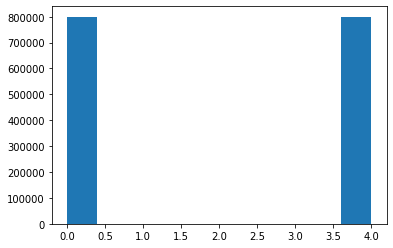

In [0]:
_ = plt.hist(train_data.loc[:, 0])

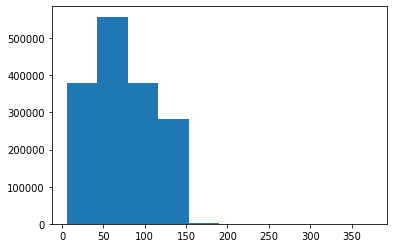

In [0]:
train_text_len = [len(row[5]) for _, row in train_data.iterrows()]
_ = plt.hist(train_text_len)

## Cleaning

Drop unnecessary columns 

In [0]:
train_data.drop([1, 2, 3, 4], axis=1, inplace=True)
test_data.drop([1, 2, 3, 4], axis=1, inplace=True)

Rename remaining columns

In [0]:
train_data.columns = ["label", "text"]
test_data.columns = ["label", "text"]

Cleaning tweets by removing url links, tags ...

In [0]:
def clean_tweet(tweet):
    tweet = BeautifulSoup(tweet, "lxml").get_text()
    # Removing the @
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    # Removing the URL links
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    # Keeping only letters
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)
    # Removing additional whitespaces
    tweet = re.sub(r" +", ' ', tweet)
    return tweet

In [0]:
train_data.text = train_data.text.map(lambda x: clean_tweet(x))
test_data.text = test_data.text.map(lambda x: clean_tweet(x))

In [0]:
set(train_data.label)

{0, 4}

The dataset use 4 for positive tweets. Let's convert it into 1.

In [0]:
train_data.label = train_data.label.map(lambda x: 1 if x==4 else x)

Since the cleaning process takes a lot of time, I'm going to save the cleaned data into .csv files.

In [0]:
train_data.to_csv("train_tweets_cleaned.csv", index=False)
test_data.to_csv("test_tweets_cleaned.csv", index=False)

In [0]:
train_data = pd.read_csv(PATH + "train_tweets_cleaned.csv")
test_data = pd.read_csv(PATH + "test_tweets_cleaned.csv")

## Tokenization

In [0]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    train_data.text, target_vocab_size=2**16)

In [0]:
train_inputs = [tokenizer.encode(sentence) for sentence in train_data.text]
test_inputs = [tokenizer.encode(sentence) for sentence in test_data.text]

And again, for reproducibility reasons, I'm pickeling the inputs

In [0]:
MAX_LEN = max([len(sentence) for sentence in train_inputs])
train_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    train_inputs, value=0, padding="post", maxlen=MAX_LEN)
test_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    test_inputs, value=0, padding="post", maxlen=MAX_LEN)

Now that the text is tokenized and padded, we need to pad it by adding zeros to the end of all sentences so that we have equal sized elements for training.

In [0]:
with open('train_inputs', 'wb') as fh:
   pickle.dump(train_inputs, fh)
with open('test_inputs', 'wb') as fh:
   pickle.dump(test_inputs, fh)

## Spliting data

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_inputs, train_data.label, test_size=0.5, random_state=seed)

# Model building

In [0]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,  #Size of the vocabulary used. Will be given by the tokenizer
                 emb_dim=128,  #128 is just an intuitive default value, it's used so ofter for embedding 
                 nb_filters=50,  #Number of times we want to apply each filter
                 FFN_units=512,  #Number of units of the feedforward neural network at the end
                 nb_classes=2,  #Binary classification as default
                 dropout_rate=0.1,  #To turn off certain units/parameters to avoid overfitting
                 training=False,  #True if the network is in evaluation phase. Drop out will be applied only in training
                 name="dcnn"):  #A name for the network
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=3,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=4,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.pool = layers.GlobalMaxPool1D()  #We'll be using this layer for all pooling steps
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)  #This is a good place to define dropout since dense_1 with create a lot of params
        if nb_classes == 2:  #Easy way to handle multiclasses
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis=-1)  #(batch_size, 3 * nb_filters) 3 because we have 3 types of filters
        merged = self.dense_1(merged)  #Staring the feedforward process
        merged = self.dropout(merged, training)  #Applying dropout if training=True
        output = self.last_dense(merged)  
        
        return output

# Training

## Configuration

In [0]:
VOCAB_SIZE = tokenizer.vocab_size

#These are basicaly hyperparameters
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = len(set(train_data.label))

DROPOUT_RATE = 0.2

BATCH_SIZE = 16
NB_EPOCHS = 2

## Training

In [0]:
dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

I want this notebook to handle binary and multiclass classifications tasks

In [0]:
if NB_CLASSES == 2:
    dcnn.compile(loss="binary_crossentropy",  #Standard loss when doing a binary classification
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    dcnn.compile(loss="sparse_categorical_crossentropy",  #Standard loss when doing a multiclass classification
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

And again, to use the model later I'm going to make a checkpoint 

In [0]:
checkpoint_path = PATH + "checkpoints/"
ckpt = tf.train.Checkpoint(Dcnn=dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)  #Keeping the last 5 checkpoints

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

In [23]:
dcnn.fit(X_train, 
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)

ckpt_manager.save()

Epoch 1/2
50000/50000 [==============================] - 3964s 79ms/step - loss: 0.3904 - accuracy: 0.8267
Epoch 2/2
50000/50000 [==============================] - 3975s 79ms/step - loss: 0.3243 - accuracy: 0.8628


'/content/drive/My Drive/CNN for NLP datasets/checkpoints/ckpt-1'

# Evaluation

In [25]:
results = dcnn.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(results)

50000/50000 [==============================] - 126s 3ms/step - loss: 0.4445 - accuracy: 0.8232
[0.44448214769363403, 0.8231599926948547]


In [26]:
dcnn(np.array([tokenizer.encode("This notebook is awesome")]), training=False).numpy()

array([[0.8554794]], dtype=float32)